In [1]:
import math

import torch
import torch.nn.functional as F


n_ctx = 10
seqlen = 3
start_pos = 2
T = start_pos + seqlen
tokens = torch.randint(0, 100, (1, seqlen))

mask = torch.full((seqlen, seqlen), float("-inf"), device=tokens.device)
print(mask)
mask = torch.triu(mask, diagonal=1)
print(mask)
# When performing key-value caching, we compute the attention scores
# only for the new sequence. Thus, the matrix of scores is of size
# (seqlen, cache_len + seqlen), and the only masked entries are (i, j) for
# j > cache_len + i, since row i corresponds to token cache_len + i.
mask = torch.hstack([torch.zeros((seqlen, start_pos), device=tokens.device), mask])
print("mask 1")
print(mask)
mask_1 = mask

full_mask = torch.full((n_ctx, n_ctx), float("-inf"), device=tokens.device)
full_mask = torch.triu(full_mask, diagonal=1)
print(full_mask)
mask_2 = full_mask[start_pos : start_pos + seqlen, : start_pos + seqlen]
print("mask 2")
print(mask_2)

assert mask_1.all() == mask_2.all()


tensor([[-inf, -inf, -inf],
        [-inf, -inf, -inf],
        [-inf, -inf, -inf]])
tensor([[0., -inf, -inf],
        [0., 0., -inf],
        [0., 0., 0.]])
mask 1
tensor([[0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])
tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
mask 2
tensor([[0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])


In [2]:
d_head = 4
n_head = 2

# (B, n_head, T, d_head)
K = torch.randn(1, n_head, T, d_head)
V = torch.randn(1, n_head, T, d_head)
Q = torch.randn(1, n_head, seqlen, d_head)
print(f"{K.shape=}")
print(f"{V.shape=}")
print(f"{Q.shape=}")
attn_scores = Q @ K.transpose(-2, -1)
attn_scores = attn_scores / math.sqrt(d_head)
print(f"{attn_scores.shape=}")
attn_scores = attn_scores + mask_2
print(f"{attn_scores.shape=}")
attn = attn_scores.softmax(dim=-1)
print(f"{attn.shape=}")
print(attn)
z_og = attn @ V
print(f"{z_og.shape=}")
print(z_og)

z_flash = F.scaled_dot_product_attention(Q, K, V, is_causal=False, attn_mask=mask_2)
print(f"{z_flash.shape=}")
print(z_flash)


K.shape=torch.Size([1, 2, 5, 4])
V.shape=torch.Size([1, 2, 5, 4])
Q.shape=torch.Size([1, 2, 3, 4])
attn_scores.shape=torch.Size([1, 2, 3, 5])
attn_scores.shape=torch.Size([1, 2, 3, 5])
attn.shape=torch.Size([1, 2, 3, 5])
tensor([[[[0.4003, 0.4103, 0.1894, 0.0000, 0.0000],
          [0.1219, 0.0861, 0.0307, 0.7613, 0.0000],
          [0.0293, 0.2214, 0.3331, 0.3279, 0.0883]],

         [[0.2110, 0.2374, 0.5516, 0.0000, 0.0000],
          [0.6632, 0.0804, 0.2035, 0.0529, 0.0000],
          [0.0187, 0.8617, 0.0415, 0.0516, 0.0264]]]])
z_og.shape=torch.Size([1, 2, 3, 4])
tensor([[[[ 0.2763,  0.6489,  0.8115,  0.0671],
          [-1.3234, -0.6132,  1.2718,  0.6864],
          [-0.2308, -0.1575,  0.8167,  0.1487]],

         [[-0.0925, -0.6464, -0.1608, -0.0596],
          [-0.4594, -0.6890, -0.5329,  0.5221],
          [-0.0952,  0.0421,  0.3198, -0.1144]]]])
z_flash.shape=torch.Size([1, 2, 3, 4])
tensor([[[[ 0.2763,  0.6489,  0.8115,  0.0671],
          [-1.3234, -0.6132,  1.2718,  0.6864]

In [3]:
import time

from gollem.models.gpt2.config import GPT2Config
from gollem.models.gpt2.model import GPT


def generate_text(model, cfg, x):
    time_start = time.time()
    B = x.size(0)
    output = torch.zeros((B, cfg.n_ctx), device=x.device)
    for i in range(cfg.n_ctx):
        logits = model.sample(x, start_pos=i)
        x = torch.argmax(logits, dim=-1)
        output[:, i] = x.squeeze(-1)
    time_taken = time.time() - time_start
    print(f"Time taken: {time_taken} seconds")
    return time_taken, output


def compute_expected_flops(cfg):
    B = cfg.max_sample_batch_size
    T = cfg.n_ctx
    d_model = cfg.d_model
    L = cfg.n_layer
    # (B*d_model)**2 per layer L per step T
    total_flops_caching = T * L * (B * d_model) ** 2
    # (B*d_model*i)**2 per layer L per step T
    # i = 1, 2, ..., T
    total_flops_no_caching = 0
    for i in range(1, T + 1):
        total_flops_no_caching += L * (B * d_model * i) ** 2
    print(f"{total_flops_caching=}")
    print(f"{total_flops_no_caching=}")
    print(f"speedup: {total_flops_no_caching / total_flops_caching}")


/Users/jonathon/code/gollem/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jonathon/code/gollem/gollem/models/gpt2/model.py:18: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [14]:
def test_kv_caching(max_sample_batch_size: int, n_ctx: int):
    print(
        f"Testing with max_sample_batch_size={max_sample_batch_size} and n_ctx={n_ctx}"
    )
    vocab_size = 100
    x = torch.randint(0, vocab_size, (max_sample_batch_size, 1))
    cfg = GPT2Config(
        vocab_size=100,
        n_ctx=n_ctx,
        n_layer=8,
        n_head=4,
        d_model=128,
        flash=True,
        max_sample_batch_size=max_sample_batch_size,
        use_kv_caching=False,
    )
    model = GPT(cfg)
    assert model.transformer.h[0].attn.cache_x is not None
    assert model.transformer.h[0].attn.cache_k is None
    assert model.transformer.h[0].attn.cache_v is None
    no_caching_time, no_caching_output = generate_text(model, cfg, x)

    cfg = GPT2Config.override(cfg, use_kv_caching=True)
    model = GPT(cfg)
    assert model.transformer.h[0].attn.cache_x is None
    assert model.transformer.h[0].attn.cache_k is not None
    assert model.transformer.h[0].attn.cache_v is not None
    caching_time, caching_output = generate_text(model, cfg, x)

    assert no_caching_output.allclose(caching_output)
    speedup = no_caching_time / caching_time

    # compute_expected_flops(cfg)
    return speedup, no_caching_time, caching_time


In [ ]:
speedups = {}
for b in [1, 2, 4, 8, 16, 32, 64]:
    speedup, no_caching_time, caching_time = test_kv_caching(b, 512)
    speedups[b] = (speedup, no_caching_time, caching_time)

print("B    | speedup")
print("-" * 10)
for b, speedup in speedups.items():
    print(f"{b:4d} | {speedup[0]:6.2f}")

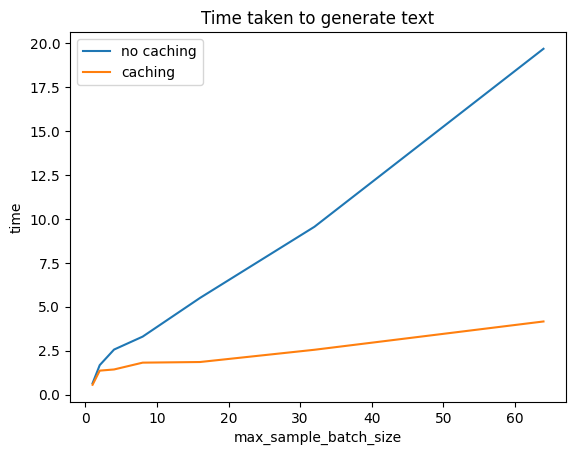

In [15]:
import matplotlib.pyplot as plt


no_caching_times = [speedup[1] for speedup in speedups.values()]
caching_times = [speedup[2] for speedup in speedups.values()]

plt.plot(list(speedups.keys()), no_caching_times, label="no caching")
plt.plot(list(speedups.keys()), caching_times, label="caching")
plt.xlabel("max_sample_batch_size")
plt.ylabel("time")
plt.title("Time taken to generate text")
plt.legend()
plt.show()


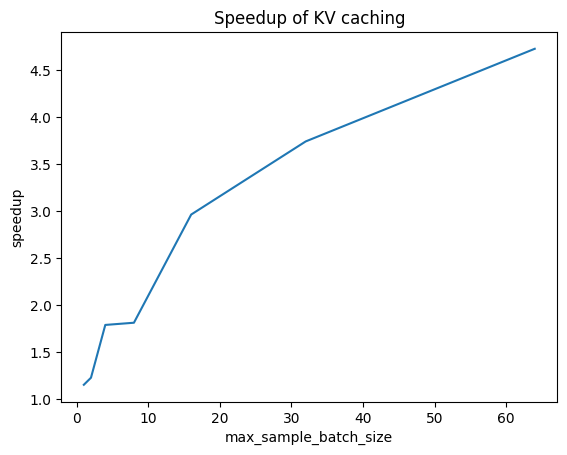

In [16]:
plt.plot(list(speedups.keys()), [speedup[0] for speedup in speedups.values()])
plt.xlabel("max_sample_batch_size")
plt.ylabel("speedup")
plt.title("Speedup of KV caching")
plt.show()


In [20]:
speedups_n_ctx = {}
for n_ctx in [128, 256, 512, 1024, 2048, 4096]:
    speedup, no_caching_time, caching_time = test_kv_caching(1, n_ctx)
    speedups_n_ctx[n_ctx] = (speedup, no_caching_time, caching_time)

print("B    | speedup")
print("-" * 10)
for b, speedup in speedups_n_ctx.items():
    print(f"{b:4d} | {speedup[0]:6.2f}")

Testing with max_sample_batch_size=1 and n_ctx=128
Time taken: 0.15488886833190918 seconds
Time taken: 0.13444280624389648 seconds
Testing with max_sample_batch_size=1 and n_ctx=256
Time taken: 0.36782288551330566 seconds
Time taken: 0.2734038829803467 seconds
Testing with max_sample_batch_size=1 and n_ctx=512
Time taken: 0.662559986114502 seconds
Time taken: 0.5525710582733154 seconds
Testing with max_sample_batch_size=1 and n_ctx=1024
Time taken: 1.510538101196289 seconds
Time taken: 1.175436019897461 seconds
Testing with max_sample_batch_size=1 and n_ctx=2048
Time taken: 4.383522033691406 seconds
Time taken: 2.5238327980041504 seconds
Testing with max_sample_batch_size=1 and n_ctx=4096
Time taken: 12.864481687545776 seconds
Time taken: 5.886627912521362 seconds
B    | speedup
----------
 128 |   1.15
 256 |   1.35
 512 |   1.20
1024 |   1.29
2048 |   1.74
4096 |   2.19


Text(0.5, 1.0, 'Time taken to generate text with different n_ctx')

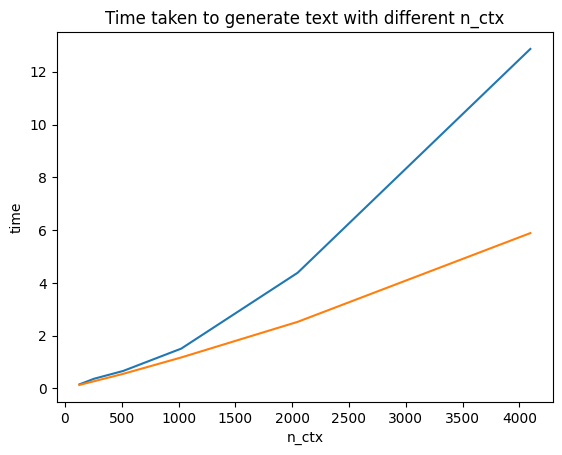

In [24]:
no_caching_times_n_ctx = [speedup[1] for speedup in speedups_n_ctx.values()]
caching_times_n_ctx = [speedup[2] for speedup in speedups_n_ctx.values()]

plt.plot(list(speedups_n_ctx.keys()), no_caching_times_n_ctx, label="no caching")
plt.plot(list(speedups_n_ctx.keys()), caching_times_n_ctx, label="caching")
plt.xlabel("n_ctx")
plt.ylabel("time")
plt.title("Time taken to generate text with different n_ctx")

Text(0.5, 1.0, 'Speedup of KV caching with different n_ctx')

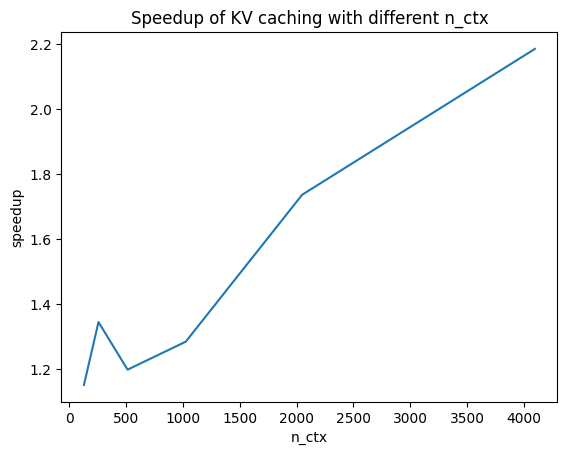

In [ ]:
plt.plot(
    list(speedups_n_ctx.keys()), [speedup[0] for speedup in speedups_n_ctx.values()]
)
plt.xlabel("n_ctx")
plt.ylabel("speedup")
plt.title("Speedup of KV caching with different n_ctx")